In [3]:
import io
import os
import math
import copy
import pickle
import zipfile
from textwrap import wrap
from pathlib import Path
from itertools import zip_longest
from collections import defaultdict
from urllib.error import URLError
from urllib.request import urlopen

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.optim.lr_scheduler import _LRScheduler

In [4]:
df = pd.read_csv('https://github.com/nkozemaslova/Data_2022/releases/download/data3/SpotifyFeatures.csv')
df.head()

df2 = pd.read_csv('https://github.com/nkozemaslova/Data_2022/releases/download/data4/spotify_dataset.csv',
                  skiprows=1,
                  names=['user_id', 'artistname', 'trackname', 'playlistname'],
                  on_bad_lines='skip')

# Переименовали колонку "artistname" во втором датасете на "artist_name"
df2 = df2.rename(columns={'artistname': 'artist_name'})

# Переименовали колнку "trackname" во втором датасете на "track_name"
df2 = df2.rename(columns={'trackname': 'track_name'})

#объединенный датасет
data = pd.merge(df, df2, on=['artist_name', 'track_name'], how='inner')
data.shape

(6208202, 20)

In [5]:
data = data[['user_id', 'track_id']].drop_duplicates()
data.shape

(2484403, 2)

In [6]:
data['track_id'].nunique(), len(data['track_id'].value_counts()[data['track_id'].value_counts().values >= 50])

(64337, 12067)

In [7]:
data['user_id'].nunique(), len(data['user_id'].value_counts()[data['user_id'].value_counts().values >= 25])

(15095, 11523)

In [8]:
print(data.shape)
data = data[data['track_id'].isin(data['track_id'].value_counts()[data['track_id'].value_counts().values >= 50].index)]
data = data[data['user_id'].isin(data['user_id'].value_counts()[data['user_id'].value_counts().values >= 25].index)]
print(data.shape)

(2484403, 2)
(1883856, 2)


In [9]:
selected_users = pd.DataFrame(data['user_id'].unique()).sample(frac=0.5)[0]
data = data[data['user_id'].isin(selected_users)]
data.shape

(921219, 2)

In [10]:
iteractins = data[['user_id', 'track_id']]
iteractins['rating'] = 1
iteractins.head()

,user_id,track_id,rating
205,6879b04def4c52a0d41e07b4f11136d6,47TqCCnEliDp8NRDyIQoQq,1
208,c4397b41b68a636a810517e59f6a476b,47TqCCnEliDp8NRDyIQoQq,1
212,c411684f86b76734deeb3739bb3ba8f7,47TqCCnEliDp8NRDyIQoQq,1
213,9a5f381ade9c41c783520568ae2fb414,47TqCCnEliDp8NRDyIQoQq,1
219,e1908ed3528f78587878788ff5522e12,47TqCCnEliDp8NRDyIQoQq,1


In [11]:
iteractins_neg = pd.DataFrame(data['user_id'].unique()).merge(pd.DataFrame(data['track_id'].unique()), how='cross').sample(frac=0.07)
iteractins_neg.columns = ['user_id', 'track_id']
iteractins_neg['rating'] = 0
iteractins_neg.head()

,user_id,track_id,rating
47768103,fcb53951b703aea91304f9361dc19015,5mGVZ3k5LefACaZwfFcGn8,0
15629478,d6fe2fadf17540f1d9d5e55061ce439d,6NdcSEhpGGAYXNnnhGS2s6,0
734475,eba3e39dff8ec3944c96c5fa8c34143b,3jtrtcE7w0mkskTzapDqn8,0
65114275,f716a9da6c1f6bf32659ff55fb167486,6UzeOH4bRPzKTo2wCXMZmC,0
1136212,c262869e7c248af3bd1e4702fc7a61e9,5ZISTTuh3YIBtYsCvBKk5w,0


In [12]:
iteractins_ = pd.concat([iteractins_neg, iteractins]).groupby(['user_id', 'track_id']).aggregate({"rating":"max"}).reset_index()
iteractins_.head()

,user_id,track_id,rating
0,0007f3dd09c91198371454c608d47f22,00cn1ynXQhURwsgv69fN0b,0
1,0007f3dd09c91198371454c608d47f22,00t7QTffOR3SA3L1BvSQVq,0
2,0007f3dd09c91198371454c608d47f22,0171XsIM2xyeXRr6wsugEI,0
3,0007f3dd09c91198371454c608d47f22,020ffiIfWvx5EH9VJ8Dkg2,0
4,0007f3dd09c91198371454c608d47f22,03GJyQfnhwq8f4NK5sOxO5,0


In [13]:
iteractins_.shape, iteractins_['rating'].mean(), iteractins_['rating'].sum()

((5442577, 3), 0.16926154650637004, 921219)

In [14]:
def tabular_preview(ratings, n=15):
    """Creates a cross-tabular view of users vs movies."""

    user_groups = ratings.groupby('user_id')['rating'].count()
    top_users = user_groups.sort_values(ascending=False)[:15]

    movie_groups = ratings.groupby('track_id')['rating'].count()
    top_movies = movie_groups.sort_values(ascending=False)[:15]

    top = (
        ratings.
        join(top_users, rsuffix='_r', how='inner', on='user_id').
        join(top_movies, rsuffix='_r', how='inner', on='track_id'))

    return pd.crosstab(top.user_id, top.track_id, top.rating, aggfunc=np.sum)

In [15]:
tabular_preview(iteractins_, 10)

track_id,0W4Kpfp1w2xkY3PrV714B7,0n4bITAu0Y0nigrz3MFJMb,2dLLR6qlu5UJ5gk0dKz0h3,32OlwWuMpZ6b0aN2RZOeMS,3a2tuvXCHbW5nuUckuHkKT,3bidbhpOYeV4knp8AIu8Xn,3gbBpTdY8lnQwqxNCcf795,3s4U7OHV7gnj42VV72eSZ6,4G8gkOterJn0Ywt6uhqbhp,4h8VwCb1MTGoLKueQ1WgbD,5FVd6KXrgO9B3JPmC8OPst,5ghIJDpPoe3CfHMGu71E6T,69kOkLUCkxIZYexIgSG8rq,6GmUVqe73u5YRfUUynZK6I,7oK9VyNzrYvRFo7nQEYkWN
user_id,,,,,,,,,,,,,,,
00dd7fde8040db835d917e077bb47e4b,NaN,NaN,1.0,NaN,1.0,1.0,1.0,NaN,1.0,1.0,0.0,1.0,1.0,1.0,1.0
05422749e89268463444e00ddea1faf1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
139c408e52a497aac29753125d65b0ae,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1d7a6816a47881ad65c4d0fb65b49c41,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1.0,NaN,NaN
3196442b472af9bbb51e1628ca3c188a,1.0,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,1.0,1.0,1.0,NaN,NaN
4398de6902abde3351347b048fcdc287,1.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,NaN,1.0,1.0,1.0
47300b211a76740722648b21a438653a,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,0.0,1.0,1.0,NaN,1.0
5974698501e05d24c6599fb5a849cc93,1.0,NaN,1.0,NaN,1.0,1.0,NaN,NaN,1.0,NaN,NaN,1.0,NaN,1.0,1.0
6752faf971cd451d87b270621979e2d5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [16]:
def create_dataset(ratings, top=None):
    if top is not None:
        ratings.groupby('user_id')['rating'].count()

    unique_users = ratings.user_id.unique()
    user_to_index = {old: new for new, old in enumerate(unique_users)}
    new_users = ratings.user_id.map(user_to_index)

    unique_tracks = ratings.track_id.unique()
    track_to_index = {old: new for new, old in enumerate(unique_tracks)}
    new_track = ratings.track_id.map(track_to_index)

    n_users = unique_users.shape[0]
    n_tracks = unique_tracks.shape[0]

    X = pd.DataFrame({'user_id': new_users, 'movie_id': new_track})
    y = ratings['rating'].astype(np.float32)
    return (n_users, n_tracks), (X, y), (user_to_index, track_to_index)

In [17]:
(n, m), (X, y), (user_to_index, track_to_index) = create_dataset(iteractins_)
print(f'Embeddings: {n} users, {m} tracks')
print(f'Dataset shape: {X.shape}')
print(f'Target shape: {y.shape}')

Embeddings: 5429 users, 12067 tracks
Dataset shape: (5442577, 2)
Target shape: (5442577,)


In [18]:
class ReviewsIterator:

    def __init__(self, X, y, batch_size=32, shuffle=True):
        X, y = np.asarray(X), np.asarray(y)

        if shuffle:
            index = np.random.permutation(X.shape[0])
            X, y = X[index], y[index]

        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.n_batches = int(math.ceil(X.shape[0] // batch_size))
        self._current = 0

    def __iter__(self):
        return self

    def __next__(self):
        return self.next()

    def next(self):
        if self._current >= self.n_batches:
            raise StopIteration()
        k = self._current
        self._current += 1
        bs = self.batch_size
        return self.X[k*bs:(k + 1)*bs], self.y[k*bs:(k + 1)*bs]

In [19]:
def batches(X, y, bs=32, shuffle=True):
    for xb, yb in ReviewsIterator(X, y, bs, shuffle):
        xb = torch.LongTensor(xb)
        yb = torch.FloatTensor(yb)
        yield xb, yb.view(-1, 1)

In [20]:
for x_batch, y_batch in batches(X, y, bs=4):
    print(x_batch)
    print(y_batch)
    break

tensor([[ 1598, 11036],
        [ 5354,  2701],
        [ 2562, 10375],
        [ 4948,  8881]])
tensor([[0.],
        [0.],
        [0.],
        [1.]])


In [21]:
class EmbeddingNet(nn.Module):
    """
    Creates a dense network with embedding layers.

    Args:

        n_users:
            Number of unique users in the dataset.

        n_movies:
            Number of unique movies in the dataset.

        n_factors:
            Number of columns in the embeddings matrix.

        embedding_dropout:
            Dropout rate to apply right after embeddings layer.

        hidden:
            A single integer or a list of integers defining the number of
            units in hidden layer(s).

        dropouts:
            A single integer or a list of integers defining the dropout
            layers rates applyied right after each of hidden layers.

    """
    def __init__(self, n_users, n_movies,
                 n_factors=50, embedding_dropout=0.02,
                 hidden=10, dropouts=0.2):

        super().__init__()
        hidden = get_list(hidden)
        dropouts = get_list(dropouts)
        n_last = hidden[-1]

        def gen_layers(n_in):
            """
            A generator that yields a sequence of hidden layers and
            their activations/dropouts.

            Note that the function captures `hidden` and `dropouts`
            values from the outer scope.
            """
            nonlocal hidden, dropouts
            assert len(dropouts) <= len(hidden)

            for n_out, rate in zip_longest(hidden, dropouts):
                yield nn.Linear(n_in, n_out)
                yield nn.ReLU()
                if rate is not None and rate > 0.:
                    yield nn.Dropout(rate)
                n_in = n_out

        self.u = nn.Embedding(n_users, n_factors)
        self.m = nn.Embedding(n_movies, n_factors)
        self.drop = nn.Dropout(embedding_dropout)
        self.hidden = nn.Sequential(*list(gen_layers(n_factors * 2)))
        self.fc = nn.Linear(n_last, 1)
        self._init()

    def forward(self, users, movies, minmax=None):
        features = torch.cat([self.u(users), self.m(movies)], dim=1)
        x = self.drop(features)
        x = self.hidden(x)
        out = torch.sigmoid(self.fc(x))
        if minmax is not None:
            min_rating, max_rating = minmax
            out = out*(max_rating - min_rating + 1) + min_rating - 0.5
        return out

    def _init(self):
        """
        Setup embeddings and hidden layers with reasonable initial values.
        """

        def init(m):
            if type(m) == nn.Linear:
                torch.nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)

        self.u.weight.data.uniform_(-0.05, 0.05)
        self.m.weight.data.uniform_(-0.05, 0.05)
        self.hidden.apply(init)
        init(self.fc)


def get_list(n):
    if isinstance(n, (int, float)):
        return [n]
    elif hasattr(n, '__iter__'):
        return list(n)
    raise TypeError('layers configuraiton should be a single number or a list of numbers')

In [22]:
EmbeddingNet(n, m, n_factors=150, hidden=[100, 200, 300], dropouts=[0.25, 0.5])

EmbeddingNet(
  (u): Embedding(5429, 150)
  (m): Embedding(12067, 150)
  (drop): Dropout(p=0.02, inplace=False)
  (hidden): Sequential(
    (0): Linear(in_features=300, out_features=100, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=100, out_features=200, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=200, out_features=300, bias=True)
    (7): ReLU()
  )
  (fc): Linear(in_features=300, out_features=1, bias=True)
)

In [23]:
class CyclicLR(_LRScheduler):

    def __init__(self, optimizer, schedule, last_epoch=-1):
        assert callable(schedule)
        self.schedule = schedule
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        return [self.schedule(self.last_epoch, lr) for lr in self.base_lrs]

In [24]:
def triangular(step_size, max_lr, method='triangular', gamma=0.99):

    def scheduler(epoch, base_lr):
        period = 2 * step_size
        cycle = math.floor(1 + epoch/period)
        x = abs(epoch/step_size - 2*cycle + 1)
        delta = (max_lr - base_lr)*max(0, (1 - x))

        if method == 'triangular':
            pass  # we've already done
        elif method == 'triangular2':
            delta /= float(2 ** (cycle - 1))
        elif method == 'exp_range':
            delta *= (gamma**epoch)
        else:
            raise ValueError('unexpected method: %s' % method)

        return base_lr + delta

    return scheduler

In [25]:
def cosine(t_max, eta_min=0):

    def scheduler(epoch, base_lr):
        t = epoch % t_max
        return eta_min + (base_lr - eta_min)*(1 + math.cos(math.pi*t/t_max))/2

    return scheduler

In [26]:
def plot_lr(schedule):
    ts = list(range(1000))
    y = [schedule(t, 0.001) for t in ts]
    plt.plot(ts, y)

In [27]:
def set_random_seed(state=1):
    gens = (np.random.seed, torch.manual_seed, torch.cuda.manual_seed)
    for set_state in gens:
        set_state(state)

In [28]:
RANDOM_STATE = 1
set_random_seed(RANDOM_STATE)


X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=RANDOM_STATE)
datasets = {'train': (X_train, y_train), 'val': (X_valid, y_valid)}
dataset_sizes = {'train': len(X_train), 'val': len(X_valid)}

In [29]:
minmax = float(iteractins_.rating.min()), float(iteractins_.rating.max())
minmax

(0.0, 1.0)

In [30]:
net = EmbeddingNet(
    n_users=n, n_movies=m,
    n_factors=150, hidden=[500, 500, 500],
    embedding_dropout=0.05, dropouts=[0.5, 0.5, 0.25])

In [31]:
lr = 1e-3
wd = 1e-5
bs = 2000
n_epochs = 100
patience = 10
no_improvements = 0
best_loss = np.inf
best_weights = None
history = []
lr_history = []

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

net.to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
iterations_per_epoch = int(math.ceil(dataset_sizes['train'] // bs))
scheduler = CyclicLR(optimizer, cosine(t_max=iterations_per_epoch * 2, eta_min=lr/10))

In [32]:
for epoch in range(n_epochs):
    stats = {'epoch': epoch + 1, 'total': n_epochs}

    for phase in ('train', 'val'):
        if phase == 'train':
          training = True
        else:
          training = False

        running_loss = 0
        n_batches = 0

        for batch in batches(*datasets[phase], shuffle=training, bs=bs):
            x_batch, y_batch = [b.to(device) for b in batch]
            optimizer.zero_grad()

            #print(x_batch[:,0])


            # compute gradients only during 'train' phase
            with torch.set_grad_enabled(training):
                outputs = net(x_batch[:,0], x_batch[:,1], minmax)
                loss = criterion(outputs, y_batch)

                # don't update weights and rates when in 'val' phase
                if training:
                    scheduler.step()
                    loss.backward()
                    optimizer.step()
                    lr_history.extend(scheduler.get_lr())

            running_loss += loss.item()

        epoch_loss = running_loss / dataset_sizes[phase]
        stats[phase] = epoch_loss

        # early stopping: save weights of the best model so far
        if phase == 'val':
            if epoch_loss < best_loss:
                print('loss improvement on epoch: %d' % (epoch + 1))
                best_loss = epoch_loss
                best_weights = copy.deepcopy(net.state_dict())
                no_improvements = 0
            else:
                no_improvements += 1

    history.append(stats)
    print('[{epoch:03d}/{total:03d}] train: {train:.4f} - val: {val:.4f}'.format(**stats))
    if no_improvements >= patience:
        print('early stopping after epoch {epoch:03d}'.format(**stats))
        break

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


loss improvement on epoch: 1
[001/100] train: 0.1123 - val: 0.1070
loss improvement on epoch: 2
[002/100] train: 0.1024 - val: 0.1021
loss improvement on epoch: 3
[003/100] train: 0.0996 - val: 0.0957
loss improvement on epoch: 4
[004/100] train: 0.0891 - val: 0.0911
loss improvement on epoch: 5
[005/100] train: 0.0886 - val: 0.0886
loss improvement on epoch: 6
[006/100] train: 0.0806 - val: 0.0856
loss improvement on epoch: 7
[007/100] train: 0.0820 - val: 0.0846
loss improvement on epoch: 8
[008/100] train: 0.0747 - val: 0.0824
[009/100] train: 0.0772 - val: 0.0825
loss improvement on epoch: 10
[010/100] train: 0.0706 - val: 0.0811
loss improvement on epoch: 11
[011/100] train: 0.0736 - val: 0.0809
loss improvement on epoch: 12
[012/100] train: 0.0672 - val: 0.0798
[013/100] train: 0.0707 - val: 0.0800
loss improvement on epoch: 14
[014/100] train: 0.0646 - val: 0.0796
[015/100] train: 0.0682 - val: 0.0797
loss improvement on epoch: 16
[016/100] train: 0.0622 - val: 0.0794
[017/100] 

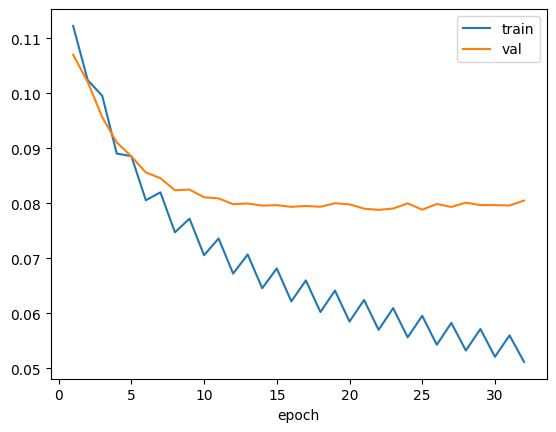

In [33]:
ax = pd.DataFrame(history).drop(columns='total').plot(x='epoch')

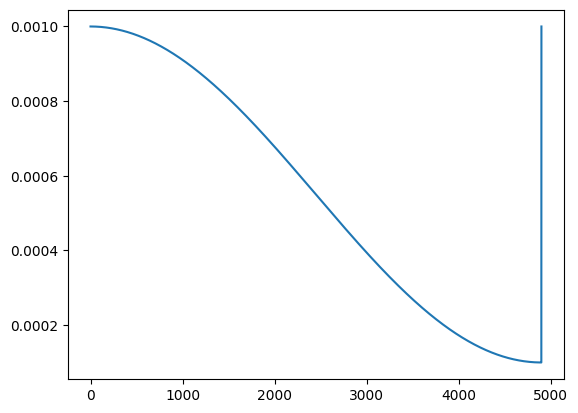

In [34]:
_ = plt.plot(lr_history[:2*iterations_per_epoch])


In [35]:
net.load_state_dict(best_weights)


<All keys matched successfully>

In [36]:
groud_truth, predictions, groud_iteractions = [], [], []

with torch.no_grad():
    for batch in batches(*datasets['val'], shuffle=False, bs=bs):
        x_batch, y_batch = [b.to(device) for b in batch]
        outputs = net(x_batch[:, 0], x_batch[:, 1], minmax)
        groud_truth.extend(y_batch.tolist())
        groud_iteractions.extend(x_batch.tolist())
        predictions.extend(outputs.tolist())

groud_truth = np.asarray(groud_truth).ravel()
predictions = np.asarray(predictions).ravel()

In [37]:
final_loss = np.sqrt(np.mean((predictions - groud_truth)**2))
print(f'Final RMSE: {final_loss:.4f}')

Final RMSE: 0.2812


In [38]:
result = pd.DataFrame(np.array(groud_iteractions), columns=["users", "items"])

In [39]:
result['actual'] = groud_truth
result['predict'] = predictions
result = result.sort_values('predict', ascending=False)

In [40]:
result['top'] = result.groupby(['users']).aggregate({'items':"cumcount"})

In [41]:
result_agg = result[result['top'] < 10].groupby(['users']).aggregate({"actual":"sum", "predict":"count"})
(result_agg['actual']/result_agg['predict']).mean()

0.5696260821514091

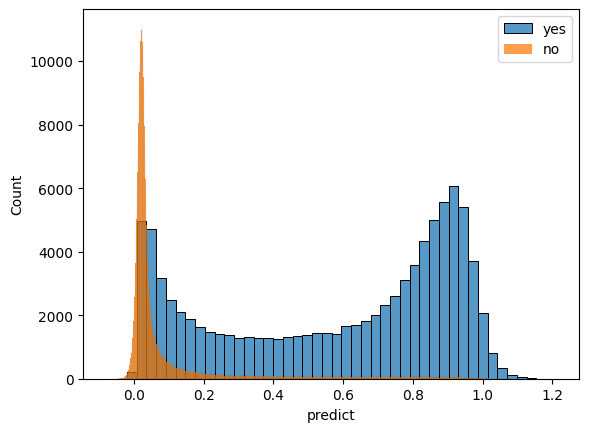

In [42]:
import seaborn as sns
sns.histplot(result[result['actual'] == 1]['predict'], label="yes")
sns.histplot(result[result['actual'] == 0]['predict'], label="no")
plt.legend()

In [178]:
datasets['val'][0]["user_id"].nunique()

5429

In [179]:
datasets_val_unsers = pd.DataFrame(datasets['val'][0]["user_id"].unique()).sample(frac=0.02)
test_songs = datasets_val_unsers.merge(pd.DataFrame(track_to_index.values()), how='cross')
seen = datasets['train'][0][datasets['train'][0]['user_id'].isin(test_songs['0_x'].unique()) & datasets['train'][0].index.isin(datasets['train'][1][datasets['train'][1] == 1].index)]

In [180]:
test_songs = list(test_songs.values)
seen = list(seen.values)
test_songs = pd.DataFrame(test_songs + seen).drop_duplicates(keep=False)

In [181]:
test_songs.columns = ['user_id','track_id']

In [182]:
test_songs.head()

,user_id,track_id
0,66,0
1,66,1
2,66,2
3,66,3
4,66,4


In [183]:
test_actual = datasets['val'][0]

In [184]:
test_actual['seen'] = datasets['val'][1]

In [185]:
test_actual = test_actual[test_actual['seen'] == 1]

In [186]:
test_actual

,user_id,movie_id,seen
258013,256,10839,1.0
2975603,2970,3915,1.0
4338227,4331,5111,1.0
3511498,3506,9079,1.0
4067141,4060,11530,1.0
...,...,...,...
2086023,2083,2605,1.0
2085656,2083,3911,1.0
3121867,3110,1617,1.0
3800878,3797,3001,1.0


In [187]:
test_songs['rating'] = 0
test_songs

,user_id,track_id,rating
0,66,0,0
1,66,1,0
2,66,2,0
3,66,3,0
4,66,4,0
...,...,...,...
1315298,794,12062,0
1315299,794,12063,0
1315300,794,12064,0
1315301,794,12065,0


In [188]:
(n, m), (X, y), (user_to_index, track_to_index) = create_dataset(test_songs)
print(f'Embeddings: {n} users, {m} tracks')
print(f'Dataset shape: {X.shape}')
print(f'Target shape: {y.shape}')

Embeddings: 109 users, 12067 tracks
Dataset shape: (1300042, 2)
Target shape: (1300042,)


In [189]:
datasets_val = {'val': (X, y)}
groud_truth, predictions, groud_iteractions = [], [], []

with torch.no_grad():
    for batch in batches(*datasets_val['val'], shuffle=False, bs=bs):
        x_batch, y_batch = [b.to(device) for b in batch]
        outputs = net(x_batch[:, 0], x_batch[:, 1], minmax)
        groud_truth.extend(y_batch.tolist())
        groud_iteractions.extend(x_batch.tolist())
        predictions.extend(outputs.tolist())

groud_truth = np.asarray(groud_truth).ravel()
predictions = np.asarray(predictions).ravel()

In [190]:
result_test = pd.DataFrame(np.array(groud_iteractions), columns=["users", "items"])
result_test['predict'] = predictions
result_test = result.sort_values('predict', ascending=False)

In [191]:
result_test.head()

,users,items,actual,predict,top
432808,523,8827,0.0,1.212142,0
344922,4862,5845,1.0,1.209810,0
2106,3042,10331,1.0,1.205391,0
91858,5300,263,1.0,1.199216,0
127651,2558,8110,1.0,1.195905,0


In [192]:
result_test = result_test[result_test['top'] < 10]

In [193]:
test_actual.columns = ['users', 'items', 'actual']
result_test = result_test[['users', 'items', 'predict']].merge(test_actual, on=['users', 'items'],how='left')

In [194]:
result_test['actual'] = result_test['actual'].fillna(0)

In [196]:
result_test['actual'].mean()

0.5696261